# Multimodal Modeling Explorations

In [1]:
import csv, os, sys, re, string, json, glob, shutil, random, datetime, math

import cv2
import pandas as pd
import numpy as np

from IPython.display import HTML as html_print
from IPython.display import Markdown
from IPython.display import clear_output

# from IPython.display import Image
from PIL import Image, ImageDraw, ImageFont
from ipywidgets import Video

import torch
from transformers import AutoTokenizer
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%pylab inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, "../all_visualizations")
sys.path.insert(0, "../data_processing")

from visualization_utils import *
from sequencing_utils import show_one_sampled_data as show_one_sampled_data_wikihow
from sequencing_data_processors import WikiHowGeneralProcessor

## Declare Multimodal Modelings

In [3]:
from lavis.models import model_zoo
from lavis.models import load_model_and_preprocess

print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
blip2_opt                      pretrain_opt2.7b, pretrain_opt6.7b, caption_coco_opt2.7b, caption_coco_opt6.7b
blip2_t5                       pretrain_flant5xl, pretrain_flant5xxl, caption_coco_flant5xl
blip2                          pretrain, coco
pnp_vqa                        base, large, 3b
pnp_unifiedqav2_fid

### Captioning Model

In [4]:
# CPU device for the try-outs.
device = torch.device("cpu")

model, vis_processors, _ = load_model_and_preprocess(
    name="blip_caption",
    model_type="base_coco",
    is_eval=True,
    device=device
)

## Ego4D Datasets

In [5]:
# Use annotations to filter out the videos list we want.
annots_root = "/local1/hu528/ego4d_data_old/v1/annotations/"
curr_videos_root = "/local1/jrbronkar/ego4d_videos/v1/full_scale"
curr_videos_root = "/local1/hu528/ego4d_data/v1/full_scale"

all_narrations_file = os.path.join(annots_root, "narration.json")
all_narrations = json.load(open(all_narrations_file))

In [6]:
scod_train_file = "fho_scod_train.json"
scod_train_file = os.path.join(annots_root, scod_train_file)

scod_val_file = "fho_scod_val.json"
scod_val_file = os.path.join(annots_root, scod_val_file)

scod_train_data = json.load(open(scod_train_file))
scod_val_data = json.load(open(scod_val_file))

scod_clips = scod_train_data["clips"] + scod_val_data["clips"]

downloaded_video_id_and_paths = {
    x.split(".mp4")[0]: os.path.join(curr_videos_root, x)
    for x in os.listdir(curr_videos_root) if ".mp4" in x
}
print("Currently we downloaded {} ego4d videos.".format(len(downloaded_video_id_and_paths)))

downloaded_scod_clips = []

for scod_clip in scod_clips:
    video_uid = scod_clip["video_uid"]
    if video_uid in downloaded_video_id_and_paths:
        downloaded_scod_clips.append(scod_clip)

print("And there are {} clips available for scod.".format(len(downloaded_scod_clips)))

Currently we downloaded 716 ego4d videos.
And there are 31872 clips available for scod.


#### Essential Functions

In [7]:
def get_ego4d_scod_clips_and_frames(
    sampled_scod_clip,
    curr_videos_root,
    show_name="show",
    get_frames=True,
):
    video_uid = sampled_scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )
    print("Mother video: {}".format(ego4d_video_path))

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = float(frame_cnt) / float(fps)
    cap.release()

    print("The fps of video `{}` is: {} of frame counts: {} and duration: {} sec.".format(ego4d_video_path, fps, frame_cnt, duration))

    pre_frame = sampled_scod_clip["pre_frame"]["frame_number"]
    pnr_frame = sampled_scod_clip["pnr_frame"]["frame_number"]
    pos_frame = sampled_scod_clip["post_frame"]["frame_number"]

    pre_secs = pre_frame / fps
    pnr_secs = pnr_frame / fps
    pos_secs = pos_frame / fps

    pre_timestamp = str(datetime.timedelta(seconds=pre_secs))
    pnr_timestamp = str(datetime.timedelta(seconds=pnr_secs))
    pos_timestamp = str(datetime.timedelta(seconds=pos_secs))

    print(pre_frame, pnr_frame, pos_frame)
    print(pre_timestamp, pnr_timestamp, pos_timestamp)

    pre_timestamp_secs = math.floor(float(pre_timestamp.split(":")[-1]))
    pos_timestamp_secs = math.ceil(float(pos_timestamp.split(":")[-1]))

    pre_timestamp = ":".join(pre_timestamp.split(":")[:-1]) + ":" + str(pre_timestamp_secs)
    pos_timestamp = ":".join(pos_timestamp.split(":")[:-1]) + ":" + str(pos_timestamp_secs)

    # show_name = "show"
    if os.path.exists("./media/{}.mp4".format(show_name)):
        os.remove("./media/{}.mp4".format(show_name))

    ffmpeg_video_cmd = (
        "/home/telinwu/ffmpeg-git-20220910-amd64-static/ffmpeg -ss {} -to {} "
        "-i {} -c copy -loglevel panic ./media/{}.mp4".format(
            pre_timestamp,
            pos_timestamp,
            ego4d_video_path,
            show_name,
        )
    )
    os.system(ffmpeg_video_cmd)
    print("Executed command: {}".format(ffmpeg_video_cmd))
    
    if get_frames:
        for frame_name in ["pre_frame", "pnr_frame", "post_frame"]:
            if os.path.exists("./media/{}.png".format(frame_name)):
                os.remove("./media/{}.png".format(frame_name))
            frame_cnt = sampled_scod_clip[frame_name]["frame_number"]
            ffmpeg_frame_cmd = (
                "/home/telinwu/ffmpeg-git-20220910-amd64-static/ffmpeg "
                "-i {} "
                "-vf select='between(n\,{}\,{})' -vsync 0 "
                "-loglevel panic ./media/{}.png".format(
                    ego4d_video_path,
                    frame_cnt,
                    frame_cnt,
                    frame_name,
                )
            )
            os.system(ffmpeg_frame_cmd)
            print("Executed command: {}".format(ffmpeg_frame_cmd))

    # pprint.pprint(sampled_scod_clip)
    return video_uid, {"pre_frame": pre_frame, "pnr_frame": pnr_frame, "post_frame": pos_frame}
    
    
def get_scod_clipped_narrations(
    scod_clip,
    all_narrations,
    curr_videos_root,
    narration_pass="narration_pass_1",
    anchor_frame="pre",
    top_k=5,
    verbose=False,
):    
    video_uid = scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if verbose:
        print(ego4d_video_path, fps)
    duration = float(frame_cnt) / float(fps)
    cap.release()
    
    clip_uid = scod_clip["clip_uid"]
    pre_frame = scod_clip["pre_frame"]
    pnr_frame = scod_clip["pnr_frame"]
    pos_frame = scod_clip["post_frame"]
    if narration_pass not in all_narrations[video_uid]:
        return [], []
    curr_narrations = all_narrations[video_uid][narration_pass]["narrations"]
    
    obj_of_changes = []
    for frame in ["pre", "pnr", "post"]:
        obj_info = scod_clip["{}_frame".format(frame)]["bbox"]
        for o in obj_info:
            if o["object_type"] == "object_of_change":
                obj_of_changes.append(o["structured_noun"])
    obj_of_changes = sorted(list(set(obj_of_changes)))
    
    pre_frame_num = pre_frame["frame_number"]
    pnr_frame_num = pnr_frame["frame_number"]
    pos_frame_num = pos_frame["frame_number"]
    
    pre_frame_sec = round(pre_frame_num/fps, 2)
    pnr_frame_sec = round(pnr_frame_num/fps, 2)
    pos_frame_sec = round(pos_frame_num/fps, 2)
    
    clip_narrations = []
    closest_narrations = []
    for i in range(len(curr_narrations)-1):
        timestamp_sec = curr_narrations[i]["timestamp_sec"]
        timestamp_frame = curr_narrations[i]["timestamp_frame"]
        next_timestamp_sec = curr_narrations[i+1]["timestamp_sec"]
        next_timestamp_frame = curr_narrations[i+1]["timestamp_frame"]
        narration_text = curr_narrations[i]["narration_text"]
        if (
            timestamp_frame >= pre_frame_num
            and timestamp_frame <= pos_frame_sec
        ):
            clip_narrations.append((
                timestamp_sec, timestamp_frame,
                next_timestamp_sec, next_timestamp_frame,
                narration_text,
            ))
            
        anchor_frame_num = scod_clip["{}_frame".format(anchor_frame)]["frame_number"]
        closest_narrations.append((
            abs(timestamp_frame-anchor_frame_num),
            timestamp_sec, timestamp_frame,
            next_timestamp_sec, next_timestamp_frame,
            narration_text,
        ))
        
    closest_narrations = sorted(closest_narrations)[:top_k]
    closest_narrations = [(a, b, c, d, e) for _, a, b, c, d, e in closest_narrations]
    
    if verbose:
        print("FPS: {}".format(fps))
        print("Object of change: {}".format(obj_of_changes))
        print("Pre/PNR/Post frame = {} / {} / {}".format(pre_frame_num, pnr_frame_num, pos_frame_num))
        print("Pre/PNR/Post sec   = {} / {} / {}".format(
            str(datetime.timedelta(seconds=pre_frame_sec))[:10],
            str(datetime.timedelta(seconds=pnr_frame_sec))[:10],
            str(datetime.timedelta(seconds=pos_frame_sec))[:10])
        )

    tagged_closest_narrations = []
    for a, b, c, d, e in closest_narrations:
        tag, tag_str = False, ""
        if (b > pre_frame_num and b < pos_frame_num) or (d > pre_frame_num and d < pos_frame_num):
            tag, tag_str = True, "(v)"
        if verbose:
            print(
                "[{}-{}]({}-{}) {} {}".format(
                    str(datetime.timedelta(seconds=a))[:10],
                    str(datetime.timedelta(seconds=c))[:10],
                    b, d, e, tag_str,
                )
            )
        tagged_closest_narrations.append((tag, a, b, c, d, e))
    
    return clip_narrations, tagged_closest_narrations


def draw_bbox_on_image(image, bbox_list, object_name=None, bbox_width=2, label_font_size=12, outline_color="white"):
    # Read images and draw rectangles.
    if type(image) is str:  # An image path.
        im = Image.open(image)
    else:
        im = image
    draw = ImageDraw.Draw(im)
    # Get a font.
    font = ImageFont.truetype("../all_visualizations/arial.ttf", size=label_font_size)
    offset = 2
    
    verts = bbox_list
    draw.rectangle(
        [(verts[0], verts[1]), (verts[0] + verts[2], verts[1] + verts[3])],
        width=bbox_width,
        outline=outline_color,
    )
    # Draw text with black background.
    text = object_name
    if text is None:
        text = "NULL"
    text_width, text_height = font.getsize(text)
    draw.rectangle(
        (
            verts[0] + offset,
            verts[1] + offset,
            verts[0] + 2 * offset + text_width,
            verts[1] + 2 * offset + text_height,
        ),
        fill="black",
    )
    draw.text(
        (verts[0] + offset, verts[1] + offset),
        text,
        fill=(255, 255, 255),
        font=font,
    )
    
    return im

### For GLIP 

#### Essential Functions

In [8]:
def create_glip_config_file(
    narration,
    video_uid,
    frames_dict,
    glip_images_folder="../../GLIP/DATASET/ego4d/frames/test",
    glip_config_file_template="../../GLIP/configs/ego4d/ego4d_template.yaml",
    glip_config_file_output="../../GLIP/configs/ego4d/ego4d_test.yaml",
    move_images=True,
    processed_scod_image_folder=None,
):
    narration_tokens = word_tokenize(narration)
    is_noun = lambda pos: pos[:2] == 'NN'
    narration_nouns = sorted(list(set([word for (word, pos) in nltk.pos_tag(narration_tokens) if is_noun(pos)])))
    if "C " in narration:
        narration_nouns.pop(narration_nouns.index("C"))

    print(narration)
    print(narration_nouns)

    override_category = []
    override_category_mapping = {}
    caption_prompt = []
    override_category_id = 1
    for noun in narration_nouns:
        override_category.append({
            "id": override_category_id,
            "name": noun,
            "supercategory": "objects",
        })
        override_category_mapping[override_category_id] = noun
        override_category_id += 1

        prefix = []
        name = []
        suffix = []
        now_suffix = False
        for token in narration_tokens:
            if token == noun:
                name.append(noun)
                now_suffix = True
            elif now_suffix:
                suffix.append(token)
            else:
                prefix.append(token)
        prefix = " ".join(prefix)
        name = " ".join(name)
        suffix = " ".join(suffix)
        caption_prompt.append({
            "prefix": prefix,
            "name": name,
            "suffix": suffix,
        })

    num_classes = len(narration_nouns)

    to_revise = {
        "CAPTION_PROMPT": str(caption_prompt),
        "OVERRIDE_CATEGORY": str(override_category),
        "NUM_CLASSES": str(num_classes+1),
        "img_dir": "ego4d/frames/test",
        "ann_file": "ego4d_test_tmp.json",
    }
    
    if processed_scod_image_folder is not None:
        to_revise["img_dir"] = processed_scod_image_folder

    pprint.pprint(to_revise)
    # print(video_uid, pre_frame, pnr_frame, post_frame)

    # Copy frames to GLIP folder
    if move_images:
        for frame in ["pre_frame", "pnr_frame", "post_frame"]:
            src_img = "./media/{}.png".format(frame)
            dst_img = os.path.join(
                glip_images_folder,
                "{}_{}.png".format(video_uid, frames_dict[frame])
            )
            print("Moving image from {} to {}".format(src_img, dst_img))
            shutil.copy(src_img, dst_img)

    glip_config_file_output = open(glip_config_file_output, "w")

    for line in open(glip_config_file_template):
        line = line.rstrip()
        for key in to_revise:
            if key in line and key == "ann_file":
                line = line.replace("ego4d_test", "ego4d_test_tmp")
            elif key in line and key != "NUM_CLASSES":
                line = line.replace("TODO", to_revise[key].replace("\'", "\""))
            elif key in line:
                line = "    NUM_CLASSES: {}".format(to_revise[key])
        glip_config_file_output.write(line+"\n")
    glip_config_file_output.close()
    
    return override_category, override_category_mapping, caption_prompt, narration_tokens

In [9]:
def create_glip_dataset_file(
    override_category,
    video_uid,
    frames_dict,
    coco_annots_test_json="../../GLIP/DATASET/ego4d/annotations/image_info_test-dev2017.json",
    output_dataset_file="../../GLIP/DATASET/ego4d/annotations/ego4d_test.json",
    processed_scod_image_folder=None,
):
    coco_annots_test = json.load(open(coco_annots_test_json))
    print(coco_annots_test.keys())
    pprint.pprint(coco_annots_test["images"][0])

    new_d = {
        "info": coco_annots_test["info"],
        "images": [],
        "licenses": coco_annots_test["licenses"],
        "categories": override_category,
    }

    for frame in ["pre_frame", "pnr_frame", "post_frame"]:
        
        if frame not in frames_dict:
            continue
        
        if processed_scod_image_folder is not None:
            file_name = "{}/{}.png".format(video_uid, frames_dict[frame])
            file_path = os.path.join(processed_scod_image_folder, file_name)
        else:
            file_name = "{}_{}.png".format(video_uid, frames_dict[frame])
            file_path = os.path.join(glip_images_folder,
                "{}_{}.png".format(video_uid, frames_dict[frame]))
        assert os.path.exists(file_path), "Image {} does not exist!".format(file_path)
        
        img = Image.open(file_path)
        width = img.width
        height = img.height
        image_d = {
            "coco_url": "",
            "date_captured": "",
            "file_name": file_name,
            "height": height,
            "width": width,
            "license": 6,
            "id": "{}_{}".format(video_uid, frames_dict[frame]),
        }
        new_d["images"].append(image_d)

    json.dump(
        new_d,
        open(output_dataset_file, "w"),
        indent=4,
    )
    
    return output_dataset_file

In [10]:
def plot_glip_bboxes(
    video_uid,
    frames_dict,
    narration_tokens,
    override_category_mapping,
    top_k_bboxes=3,
    pred_bboxes_file ="../../GLIP/test_ego4d_eval_outputs_tmp/eval/glip_tiny_model_o365_goldg_cc_sbu/inference/test/bbox.json",
    glip_images_folder="../../GLIP/DATASET/ego4d/frames/test",
    resize_image_width=None,
    processed_scod_image_folder=None,
):
    pred_bboxes = json.load(open(pred_bboxes_file))
    pred_bboxes_on_images = {}
    for bbox in pred_bboxes:
        image_id = bbox["image_id"]
        if processed_scod_image_folder is not None:
            curr_video_uid, curr_frame_cnt = image_id.split("_")
            img_path = os.path.join(
                processed_scod_image_folder,
                "{}/{}.png".format(curr_video_uid, curr_frame_cnt)
            )
        else:
            img_path = os.path.join(
                glip_images_folder,
                "{}.png".format(image_id)
            )
        assert os.path.exists(img_path)
        if image_id not in pred_bboxes_on_images:
            pred_bboxes_on_images[image_id] = {
                "img_path": img_path,
                "bboxes": []
            }
        pred_bboxes_on_images[image_id]["bboxes"].append({
            "score": bbox["score"],
            "bbox": bbox["bbox"],
            "label": override_category_mapping[bbox["category_id"]]
        })

    for image_id in pred_bboxes_on_images:
        pred_bboxes_on_images[image_id]["bboxes"] = sorted(
            pred_bboxes_on_images[image_id]["bboxes"],
            key=lambda x: x["score"],
            reverse=True
        )

    # pprint.pprint(pred_bboxes_on_images)
    frame_images = {}
    for frame in ["pre_frame", "pnr_frame", "post_frame"]:
        if frame not in frames_dict:
            continue
        if processed_scod_image_folder is not None:
            _img = os.path.join(
                processed_scod_image_folder,
                "{}/{}.png".format(video_uid, frames_dict[frame])
            )
        else:
            _img = os.path.join(
                glip_images_folder,
                "{}_{}.png".format(video_uid, frames_dict[frame])
            )
        frame_images[frame] = _img

    for frame in ["pre_frame", "pnr_frame", "post_frame"]:
        print("Frame: {}".format(frame))
        print("Narrations: {}".format(narration_tokens))
        if frame not in frame_images:
            continue
        frame_image = Image.open(frame_images[frame])
        frame_image_id = "{}_{}".format(video_uid, frames_dict[frame])
        bboxed_frame_image = frame_image
        if frame_image_id in pred_bboxes_on_images:
            bboxes = pred_bboxes_on_images[frame_image_id]["bboxes"]
            for bbox_info in bboxes[:top_k_bboxes]:
                bbox = bbox_info["bbox"]
                bboxed_frame_image = draw_bbox_on_image(
                    bboxed_frame_image,
                    [bbox[0], bbox[1], bbox[2], bbox[3]],
                    bbox_info["label"]+": {:.4f}".format(bbox_info["score"]),
                    bbox_width=4,
                    label_font_size=30,
                )
        if (
            resize_image_width is not None
            and (type(resize_image_width) is int or
                 type(resize_image_width) is float)
        ):
            wpercent = (resize_image_width / float(bboxed_frame_image.size[0]))
            hsize = int((float(bboxed_frame_image.size[1]) * float(wpercent)))
            bboxed_frame_image = bboxed_frame_image.resize((resize_image_width, hsize), Image.Resampling.LANCZOS)
        display(bboxed_frame_image)

In [11]:
def glip_inference_for_bboxes(
    narration,
    video_uid,
    frames_dict,
    glip_images_folder="../../GLIP/DATASET/ego4d/frames/test",
    glip_config_file_template="../../GLIP/configs/ego4d/ego4d_template.yaml",
    glip_config_file_output="../../GLIP/configs/ego4d/ego4d_test.yaml",
    coco_annots_test_json="../../GLIP/DATASET/ego4d/annotations/image_info_test-dev2017.json",
    output_dataset_file="../../GLIP/DATASET/ego4d/annotations/ego4d_test.json",
    run_glip_commands=[
        "sh scripts/run_glip_tmp.sh",
    ],
    pred_bboxes_file="../../GLIP/test_ego4d_eval_outputs_tmp/eval/glip_tiny_model_o365_goldg_cc_sbu/inference/test/bbox.json",
    top_k_bboxes=3,
    resize_image_width=None,
    processed_scod_image_folder=None,
):
    (override_category,
     override_category_mapping,
     caption_prompt,
     narration_tokens) = create_glip_config_file(
        narration,
        video_uid,
        frames_dict,
        glip_images_folder=glip_images_folder,
        glip_config_file_template=glip_config_file_template,
        glip_config_file_output=glip_config_file_output,
        move_images=processed_scod_image_folder is None,
        processed_scod_image_folder=processed_scod_image_folder,
    )

    create_glip_dataset_file(
        override_category,
        video_uid,
        frames_dict,
        coco_annots_test_json=coco_annots_test_json,
        output_dataset_file=output_dataset_file,
        processed_scod_image_folder=processed_scod_image_folder,
    )

    for cmd in run_glip_commands:
        os.system(cmd)
    clear_output()

    plot_glip_bboxes(
        video_uid,
        frames_dict,
        narration_tokens,
        override_category_mapping,
        top_k_bboxes=top_k_bboxes,
        pred_bboxes_file=pred_bboxes_file,
        glip_images_folder=glip_images_folder,
        resize_image_width=resize_image_width,
        processed_scod_image_folder=processed_scod_image_folder,
    )

#### Testing

In [12]:
curr_videos_root = "/local1/hu528/ego4d_data/v1/full_scale"
rand_idx = np.random.choice(np.arange(len(downloaded_scod_clips)))
# rand_idx = 14980

print("Data Index: {}".format(rand_idx))
sampled_scod_clip = downloaded_scod_clips[rand_idx]

video_uid, frames_dict = get_ego4d_scod_clips_and_frames(
    sampled_scod_clip,
    curr_videos_root,
    show_name="scod",
    get_frames=False
)

print("-"*50)
clip_narrations, closest_narrations = get_scod_clipped_narrations(
    sampled_scod_clip,
    all_narrations,
    curr_videos_root,
    narration_pass="narration_pass_1",
    top_k=5,
    verbose=True,
)
print("Main Narration:", closest_narrations[0][-1])

Data Index: 2994
Mother video: /local1/hu528/ego4d_data/v1/full_scale/9d4612dc-de21-48a6-a003-0f7485adb8cd.mp4
The fps of video `/local1/hu528/ego4d_data/v1/full_scale/9d4612dc-de21-48a6-a003-0f7485adb8cd.mp4` is: 30 of frame counts: 136657 and duration: 4555.233333333334 sec.
131057 131062 131178
1:12:48.566667 1:12:48.733333 1:12:52.600000
Executed command: /home/telinwu/ffmpeg-git-20220910-amd64-static/ffmpeg -ss 1:12:48 -to 1:12:53 -i /local1/hu528/ego4d_data/v1/full_scale/9d4612dc-de21-48a6-a003-0f7485adb8cd.mp4 -c copy -loglevel panic ./media/scod.mp4
--------------------------------------------------
/local1/hu528/ego4d_data/v1/full_scale/9d4612dc-de21-48a6-a003-0f7485adb8cd.mp4 30
FPS: 30
Object of change: ['spinach']
Pre/PNR/Post frame = 131057 / 131062 / 131178
Pre/PNR/Post sec   = 1:12:48.57 / 1:12:48.73 / 1:12:52.60
[1:12:48.77-1:12:49.38](131063-131081) #C C cuts the spinach leaves on the ground with the sickle.   (v)
[1:12:48.30-1:12:48.77](131048-131063) #C C holds some 

In [13]:
glip_images_folder = "../../GLIP/DATASET/ego4d/frames/test"
glip_config_file_template = "../../GLIP/configs/ego4d/ego4d_template.yaml"
glip_config_file_output = "../../GLIP/configs/ego4d/ego4d_test_tmp.yaml"
# Write some narrations.
narration = closest_narrations[0][-1].split("#C ")[-1].strip()
# narration = "The carabiner is now in the possession of the person who removed it from the hook."
processed_scod_image_folder = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge"
    "/pre_pnr_post_png_frames"
)

(override_category,
 override_category_mapping,
 caption_prompt,
 narration_tokens) = create_glip_config_file(
    narration,
    video_uid,
    frames_dict,
    glip_images_folder=glip_images_folder,
    glip_config_file_template=glip_config_file_template,
    glip_config_file_output=glip_config_file_output,
    move_images=processed_scod_image_folder is None,
    processed_scod_image_folder=processed_scod_image_folder,
)

C cuts the spinach leaves on the ground with the sickle.
['ground', 'sickle', 'spinach']
{'CAPTION_PROMPT': "[{'prefix': 'C cuts the spinach leaves on the', 'name': "
                   "'ground', 'suffix': 'with the sickle .'}, {'prefix': 'C "
                   "cuts the spinach leaves on the ground with the', 'name': "
                   "'sickle', 'suffix': '.'}, {'prefix': 'C cuts the', 'name': "
                   "'spinach', 'suffix': 'leaves on the ground with the sickle "
                   ".'}]",
 'NUM_CLASSES': '4',
 'OVERRIDE_CATEGORY': "[{'id': 1, 'name': 'ground', 'supercategory': "
                      "'objects'}, {'id': 2, 'name': 'sickle', "
                      "'supercategory': 'objects'}, {'id': 3, 'name': "
                      "'spinach', 'supercategory': 'objects'}]",
 'ann_file': 'ego4d_test_tmp.json',
 'img_dir': '/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_png_frames'}


FileNotFoundError: [Errno 2] No such file or directory: '../../GLIP/configs/ego4d/ego4d_test_tmp.yaml'

In [17]:
coco_annots_test_json = "../../GLIP/DATASET/ego4d/annotations/image_info_test-dev2017.json"
output_dataset_file = "../../GLIP/DATASET/ego4d/annotations/ego4d_test_tmp.json"
run_glip_commands=[
    "sh scripts/run_glip_tmp.sh",
]
processed_scod_image_folder = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge"
    "/pre_pnr_post_png_frames"
)

glip_dataset_file = create_glip_dataset_file(
    override_category,
    video_uid,
    frames_dict,
    coco_annots_test_json=coco_annots_test_json,
    output_dataset_file=output_dataset_file,
    processed_scod_image_folder=processed_scod_image_folder,
)

for cmd in run_glip_commands:
    os.system(cmd)
clear_output()

print(glip_dataset_file)

NameError: name 'override_category' is not defined

In [ ]:
processed_scod_image_folder = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge"
    "/pre_pnr_post_png_frames"
)

pred_bboxes_file = "../../GLIP/test_ego4d_eval_outputs_tmp/eval/glip_tiny_model_o365_goldg_cc_sbu/inference/test/bbox.json"
top_k_bboxes = 3

print(video_uid)
print(frames_dict)

plot_glip_bboxes(
    video_uid,
    frames_dict,
    narration_tokens,
    override_category_mapping,
    top_k_bboxes=top_k_bboxes,
    pred_bboxes_file=pred_bboxes_file,
    glip_images_folder=glip_images_folder,
    resize_image_width=800,
    processed_scod_image_folder=processed_scod_image_folder,
)

In [ ]:
glip_images_folder = "../../GLIP/DATASET/ego4d/frames/test"
glip_config_file_template = "../../GLIP/configs/ego4d/ego4d_template.yaml"
glip_config_file_output = "../../GLIP/configs/ego4d/ego4d_test_tmp.yaml"
coco_annots_test_json = "../../GLIP/DATASET/ego4d/annotations/image_info_test-dev2017.json"
output_dataset_file = "../../GLIP/DATASET/ego4d/annotations/ego4d_test_tmp.json"
run_glip_commands=[
    "sh scripts/run_glip_tmp.sh",
]
pred_bboxes_file = "../../GLIP/test_ego4d_eval_outputs_tmp/eval/glip_tiny_model_o365_goldg_cc_sbu/inference/test/bbox.json"
top_k_bboxes = 3
processed_scod_image_folder = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge"
    "/pre_pnr_post_png_frames"
)
# Write some narrations.
narration = closest_narrations[0][-1].split("#C ")[-1].strip()

glip_inference_for_bboxes(
    narration,
    video_uid,
    frames_dict,
    glip_images_folder=glip_images_folder,
    glip_config_file_template=glip_config_file_template,
    glip_config_file_output=glip_config_file_output,
    coco_annots_test_json=coco_annots_test_json,
    output_dataset_file=output_dataset_file,
    run_glip_commands=run_glip_commands,
    pred_bboxes_file=pred_bboxes_file,
    top_k_bboxes=top_k_bboxes,
    resize_image_width=800,
    processed_scod_image_folder=processed_scod_image_folder,
)

In [ ]:
processed_scod_image_folder = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge"
    "/pre_pnr_post_png_frames"
)

narration = "The carabiner is now in the possession of the person who removed it from the hook."


glip_inference_for_bboxes(
    narration,
    video_uid,
    frames_dict,
    glip_images_folder=glip_images_folder,
    glip_config_file_template=glip_config_file_template,
    glip_config_file_output=glip_config_file_output,
    coco_annots_test_json=coco_annots_test_json,
    output_dataset_file=output_dataset_file,
    run_glip_commands=run_glip_commands,
    pred_bboxes_file=pred_bboxes_file,
    top_k_bboxes=top_k_bboxes,
    resize_image_width=800,
    processed_scod_image_folder=processed_scod_image_folder,
)

### Large-Scale GLIP

In [12]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
from run_glip_baseline_on_ego4d import coco_eval_results
from coco_eval import get_avg_precision_at_iou
from coco_eval import get_single_image_results
from coco_eval import calc_precision_recall
from PIL import Image, ImageDraw, ImageFont
from transformers import CLIPProcessor, CLIPModel

curr_videos_root = "/local1/hu528/ego4d_data/v1/full_scale"

In [13]:
# Use the {video_uid}_{pnr_frame} as key to organize the scod clip annotation

keyed_scod_clips = {}
for scod_clip in downloaded_scod_clips:
    video_uid = scod_clip["video_uid"]
    pnr_frame = scod_clip["pnr_frame"]["frame_number"]
    key = "{}_{}".format(video_uid, pnr_frame)
    keyed_scod_clips[key] = scod_clip

#### Essential Functions

In [14]:
def compare_glip_results(files, frame_keys, top_k, best_k=None, first_k=None):
    res = {}
    all_keyed_results = {}
    for file in files:
        res[file] = {
            "Metrics": None
        }
        file_for_coco = file
        if type(files) is dict:
            file_for_coco = {file: files[file]}
        all_metrics, avg_metrics, keyed_results = coco_eval_results(
            file_for_coco,
            top_k=top_k,
            verbose=False,
            first_k=first_k,
            best_k=best_k,
            frame_keys=frame_keys,
        )
        res[file]["Metrics"] = avg_metrics
        all_keyed_results[file] = keyed_results
    
    for file in res:
        print("---- {} ----".format(file))
        columns = ["Frame", "AP", "AP50", "AP75"]
        if best_k is not None:
            for ap in ["AP", "AP50", "AP75"]:
                columns.append("Best-{}-{}".format(best_k, ap))
        lst = []
        for fr in ["pre", "pnr", "post"]:
            curr_lst = []
            curr_fr = "{}_frame".format(fr)
            curr_lst.append(curr_fr)
            if curr_fr in res[file]["Metrics"]:
                for ap in ["AP", "AP50", "AP75"]:
                    prec = res[file]["Metrics"][curr_fr][ap]["precision"]
                    recall = res[file]["Metrics"][curr_fr][ap]["recall"]
                    curr_lst.append(prec)
                if best_k is not None:
                    for ap in ["AP", "AP50", "AP75"]:
                        ap = "Best-{}-{}".format(best_k, ap)
                        prec = res[file]["Metrics"][curr_fr][ap]["precision"]
                        recall = res[file]["Metrics"][curr_fr][ap]["recall"]
                        curr_lst.append(prec)
            lst.append(curr_lst)
        df = pd.DataFrame(lst, columns=columns)
        print(df)
        
    return all_keyed_results


def make_keyed_glip_results(
    output_results_json_file,
    frame_keys=["pre", "pnr", "post"],
):
    output_results = json.load(open(output_results_json_file))
    res_dict = {}
    for res in output_results:
        video_uid = None
        keys = []
        for fr in frame_keys:
            if "{}_frame".format(fr) not in res:
                continue
            curr = res["{}_frame".format(fr)]
            if video_uid is None:
                video_uid = curr["video_uid"]
                keys.append(video_uid)
            frame_cnt = curr["frame_cnt"]
            keys.append(str(frame_cnt))
        if video_uid is None:
            continue
        key = "_".join(keys)
        res_dict[key] = res
    return res_dict


def visualize_glip_results_comparisons(
    named_result_tuple_list,
    top_k_bboxes=3,
    resize_image_width=None,
    frame_keys=["pre", "pnr", "post"],
    bbox_width=4,
    label_font_size=30,
    scod_clip=None,
    image_folder="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_png_frames",
    region_proposal_probings={
        "caption_func": None,
        "clip_func": None,
    },
    narration=None,
    additional_description=None,
    print_performance=False,
):
    if scod_clip is not None:
        video_uid = scod_clip["video_uid"]
    for frame_prefix in frame_keys:
        print("-"*50)
        frame = "{}_frame".format(frame_prefix)
        print("{} {}".format(bold_text(red_text("Frame:")), red_text(frame)))
        for name, res in named_result_tuple_list:
            image_path = None
            if frame not in res:
                if scod_clip is not None:
                    scod_frame_number = scod_clip[frame]["frame_number"]
                    image_path = os.path.join(image_folder, video_uid, "{}.png".format(scod_frame_number))
                    gt_bboxes = []
                    for bbox in scod_clip[frame]["bbox"]:
                        if bbox["object_type"] == "object_of_change":
                            gt_bboxes.append(bbox)
            else:
                frame_res = res[frame]
                narration_tokens = frame_res["narration_tokens"]
                print("{} {}".format(bold_text(blue_text("Method:")), blue_text(name)))
                print("{} {}".format(bold_text(magenta_text("Used Narrations (if any):")),
                                     magenta_text(str(narration_tokens))))
                image_path = os.path.join(frame_res["image_folder"], frame_res["image_name"])
                assert os.path.exists(image_path)
                gt_bboxes = frame_res["gt_bboxes"]
                if len(gt_bboxes) == 0:
                    print(red_text("No GT Bboxs for this frame!"))
            
            if image_path is None:
                continue
            frame_image = Image.open(image_path)
            bboxed_frame_image = frame_image
            
            for bbox_info in gt_bboxes:
                bbox = bbox_info["bbox"]
                bboxed_frame_image = draw_bbox_on_image(
                    bboxed_frame_image,
                    [bbox["x"], bbox["y"], bbox["width"], bbox["height"]],
                    bbox_info["structured_noun"],
                    bbox_width=bbox_width,
                    label_font_size=label_font_size,
                    outline_color="red"
                )
                
            rpn_captions = []
            bbox_performance = []

            if frame in res:
                bboxes = frame_res["pred_bboxes"]
                
                ap_gt_bboxes = [
                    [b["bbox"]["x"],
                     b["bbox"]["y"],
                     b["bbox"]["x"]+b["bbox"]["width"], 
                     b["bbox"]["y"]+b["bbox"]["height"]]
                    for b in gt_bboxes
                ]
                
                for bbox_info in bboxes[:top_k_bboxes]:
                    bbox = bbox_info["bbox"]
                    if "label" not in bbox_info:
                        continue

                    ap_pred_bboxes = [
                        [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
                    ]
                    ap_res = {"AP50": None, "AP75": None}
                    for iou_thr in [0.5, 0.75]:
                        res = get_single_image_results(ap_gt_bboxes, ap_pred_bboxes,
                                                       iou_thr=iou_thr)
                        res = calc_precision_recall({"obj": res})
                        prec, rec = res
                        ap_res["AP{}".format(int(iou_thr*100))] = prec

                    bboxed_frame_image = draw_bbox_on_image(
                        bboxed_frame_image,
                        [bbox[0], bbox[1], bbox[2], bbox[3]],
                        bbox_info["label"]+": {:.4f}".format(bbox_info["score"]),
                        bbox_width=bbox_width,
                        label_font_size=label_font_size,
                    )
                    
                    ap_res_copy = ap_res.copy()
                    ap_res_copy["bbox_score"] = bbox_info["score"]
                    bbox_performance.append(ap_res_copy)
                    
                    # Cropping captions.
                    if region_proposal_probings is not None:
                        cropped_bboxed_frame_image = Image.open(image_path).crop((
                            bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]
                        ))
                        # display(cropped_bboxed_frame_image)
                        
                        if region_proposal_probings["caption_func"] is not None:
                            lavis_caption = region_proposal_probings["caption_func"].generate(
                                {"image": vis_processors["eval"](
                                    cropped_bboxed_frame_image).unsqueeze(0).to(device)},
                                num_beams=4,
                                repetition_penalty=0.9,
                                num_captions=3,
                                use_nucleus_sampling=True,
                            )
                            # pprint.pprint(lavis_caption)
                            rpn_captions.append(
                                (cropped_bboxed_frame_image, bbox_info["score"], lavis_caption, ap_res)
                            )
                        else:
                            rpn_captions.append(
                                (cropped_bboxed_frame_image, bbox_info["score"], "NULL", ap_res)
                            )

                if (
                    resize_image_width is not None
                    and (type(resize_image_width) is int or
                         type(resize_image_width) is float)
                ):
                    wpercent = (resize_image_width / float(bboxed_frame_image.size[0]))
                    hsize = int((float(bboxed_frame_image.size[1]) * float(wpercent)))
                    bboxed_frame_image = bboxed_frame_image.resize(
                        (resize_image_width, hsize), Image.Resampling.LANCZOS)   
                    
            display(bboxed_frame_image)
            
            if len(rpn_captions) > 0:
                if region_proposal_probings["clip_func"] is not None:
                    clip_images = []
                ap_tuples_list = []
                scores = []
                for rpn_caption_idx in range(len(rpn_captions)):
                    rpn_caption = rpn_captions[rpn_caption_idx]
                    if region_proposal_probings["clip_func"] is not None:
                        clip_images.append(rpn_caption[0])
                    display(rpn_caption[0])
                    ap_res = rpn_caption[3]
                    ap_res_str = "AP50 = {}  AP75 = {}".format(ap_res["AP50"], ap_res["AP75"])
                    print("Score: {}  {}".format(rpn_caption[1], ap_res_str))
                    pprint.pprint(rpn_caption[2])
                    ap_tuples_list.append((ap_res["AP50"], ap_res["AP75"], rpn_caption_idx))
                    scores.append(rpn_caption[1])
                ap_tuples_list = sorted(ap_tuples_list, reverse=True)
                scores = np.asarray(scores)
                
                if region_proposal_probings["clip_func"] is not None:
                    assert narration is not None
                    
                    use_nouns = True
                    use_nouns = False
                    # prefix = "A  "
                    # prefix = ""
                    # prefix = "There is "
                    texts2 = None
                    
                    trimmed_narration = narration.split("#C ")[-1]
                    trimmed_narration = trimmed_narration.strip()
                    # trimmed_narration = trimmed_narration.replace("C ", "Someone ")
                    trimmed_narration = trimmed_narration.replace("C ", "")
                    if additional_description is not None:
                        trimmed_narration += " {}".format(additional_description)
                    texts = [trimmed_narration]
                    if "srl_func" in region_proposal_probings:
                        srl_model = region_proposal_probings["srl_func"]
                        srl_res = srl_model.predict(sentence=trimmed_narration)

                        parsed_args_list = extract_SRL_args(srl_res)
                        used_srl = None
                        srl_tag_to_use = None
                        text2 = []
                        # pprint.pprint(parsed_args_list)
                        for parsed_args, srl in parsed_args_list:
                            # for _arg in ["ARG2", "ARG1"]:
                            for _arg in ["V", "ARG1"]:
                                if _arg in parsed_args:
                                    use_nouns = False
                                    used_srl = srl
                                    if srl_tag_to_use is None:
                                        srl_tag_to_use = []
                                    srl_tag_to_use.append(_arg)
                                    text2.append(parsed_args[_arg])
                                    # break
                                pass
                            # if used_srl is not None:
                            #     break
                            pass
                        text2 = " ".join(text2)
                        texts2 = [text2]
                        # print(texts2)
                        print("Using tag {} for SRL parse:".format(srl_tag_to_use))
                        # raise
                        pprint.pprint(used_srl)
                        
                        if used_srl is None:
                            srl_tags = []
                        else:
                            srl_tags = used_srl["tags"]
                        
                        used_srl_nouns = []
                        if "dp_func" in region_proposal_probings:
                            dp_model = region_proposal_probings["dp_func"]
                            dp_res = dp_model.predict(sentence=trimmed_narration)
                            words = dp_res["words"]
                            pos_tags = dp_res["pos"]
                            print(words)
                            print(pos_tags)
                            
                            if len(srl_tags) == len(words) and srl_tag_to_use is not None:
                                for idx in range(len(srl_tags)):
                                    srl_tag, pos_tag = srl_tags[idx], pos_tags[idx]
                                    if (
                                        srl_tag_to_use in srl_tag
                                        and ("NOUN" in pos_tag or "DET" in pos_tag)
                                    ):
                                        used_srl_nouns.append(words[idx])
                                        
                        if len(used_srl_nouns) > 0:
                            text = prefix + " ".join(used_srl_nouns) + ""
                            texts2 = [text]
                            
                            if additional_description is not None:
                                trimmed_narration += " {}".format(additional_description)
                            
                            # texts = [trimmed_narration]
                        pass
                    
                    if use_nouns:
                        is_noun = lambda pos: pos[:2] == "NN"
                        narration_tokens = word_tokenize(narration)
                        all_nouns_narration = [w for (w, p)
                            in nltk.pos_tag(narration_tokens) if is_noun(p)]
                        while "C" in all_nouns_narration:
                            all_nouns_narration.pop(all_nouns_narration.index("C"))
                        while "hand" in all_nouns_narration:
                            all_nouns_narration.pop(all_nouns_narration.index("hand"))
                        prefix = "A picture of "
                        texts = []
                        for n in all_nouns_narration:
                            t = prefix + n + " being used."
                            texts.append(t)
                    
                    pprint.pprint(texts)
                    
                    print("Input texts: {}".format(texts))
                    clip_processor, clip_model = region_proposal_probings["clip_func"]
                    clip_inputs = clip_processor(
                        text=texts, images=clip_images, return_tensors="pt", padding=True)
                    clip_outputs = clip_model(**clip_inputs)
                    logits_per_text = clip_outputs.logits_per_text
                    probs = logits_per_text.softmax(dim=1)
                    probs = probs.detach().cpu().numpy()
                    summed_probs = np.sum(probs, axis=0)

                    if texts2 is not None:
                        print("Input texts: {}".format(texts2))
                        clip_inputs = clip_processor(
                            text=texts2, images=clip_images, return_tensors="pt", padding=True)
                        clip_outputs2 = clip_model(**clip_inputs)
                        logits_per_text2 = clip_outputs2.logits_per_text
                        probs2 = logits_per_text2.softmax(dim=1)
                        probs2 = probs2.detach().cpu().numpy()
                        summed_probs2 = np.sum(probs2, axis=0)
                    
                    # summed_probs_all = summed_probs + summed_probs2
                    # summed_probs_all = summed_probs2
                    summed_probs_all = summed_probs + scores
                    
                    # print("Text probs:\n{}".format(probs))
                    print("Summed probs:\n{}".format(summed_probs))
                    if texts2 is not None:
                        print("Summed probs2:\n{}".format(summed_probs2))
                    print("Bbox scores:\n{}".format(scores))
                    argmax = np.argmax(summed_probs_all)
                    print("Choose: {}-th Bbox".format(argmax+1))
                    print(image_path)
                
                best_bboxes = [i+1 for a, b, i in ap_tuples_list if a >= 1]
                print("Best bboxes: {}".format(best_bboxes))
                
            if print_performance:
                pprint.pprint(bbox_performance)
            
            ####
            print("-"*50)
        pass
    return None

#### Visualizations

In [15]:
# Show the overall performance.
# Currently only showing AP50.
# TODO(telinwu): add AP and AP75.

# Top k bbox to be considered for peformance evaluation.
# TODO(telinwu): make top-k and objectness score thresholding together.
top_k = 1
best_k = 4

# Frames to be used as keys, a list, can include "pre", "post".
frame_keys = ["pnr"]

# Define the inference files here.
output_results_json_file_1 = "./glip_result_json_files/ego4d_scod_val_using_narrations.json"
output_results_json_file_2 = "./glip_result_json_files/ego4d_scod_val_using_narrations_and_chatgpt.json"
output_results_json_file_3 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge"
    "/baselines/DETR"
    "/ego4dv1_pnr_objects/inference/coco_instances_results_with_gt.json"
)
output_results_json_file_4 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge"
    "/baselines/VideoIntern"
    "/ego4dv1_pnr_objects/inference/test_with_gt.json"
)
output_results_json_file_5 = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge"
    "/baselines/DETR"
    "/ego4dv2_pre_pnr_post_objects/inference/coco_instances_results_with_gt.json"
)

output_results_json_file_12 = "/local1/bryanzhou008/jarvis/ego4d/rerank/pre_post_pnr_results_with_gt.json"

# Compute overall performance.
all_keyed_results = compare_glip_results(
    [
        # output_results_json_file_1,
        # output_results_json_file_2,
        output_results_json_file_3,
        output_results_json_file_4,
        output_results_json_file_12,
#         output_results_json_file_5,
    ],
    frame_keys,
    top_k=top_k,
    first_k=None,
    best_k=best_k,
)

Total results: 12801 of /local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/baselines/DETR/ego4dv1_pnr_objects/inference/coco_instances_results_with_gt.json


Results...: 100%|███████████████████████████████████████████████████████| 12801/12801 [00:23<00:00, 553.16it/s]


Total results: 12801 of /local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/baselines/VideoIntern/ego4dv1_pnr_objects/inference/test_with_gt.json


Results...: 100%|███████████████████████████████████████████████████████| 12801/12801 [00:24<00:00, 520.56it/s]


Total results: 37592 of /local1/bryanzhou008/jarvis/ego4d/rerank/pre_post_pnr_results_with_gt.json


Results...: 100%|███████████████████████████████████████████████████████| 37592/37592 [01:12<00:00, 517.94it/s]


---- /local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/baselines/DETR/ego4dv1_pnr_objects/inference/coco_instances_results_with_gt.json ----
        Frame        AP      AP50      AP75  Best-4-AP  Best-4-AP50  Best-4-AP75
0   pre_frame  0.222034  0.423729  0.220339   0.308475     0.576271     0.322034
1   pnr_frame  0.189800  0.367568  0.170730   0.246123     0.487732     0.214533
2  post_frame  0.275000  0.500000  0.250000   0.300000     0.625000     0.250000
---- /local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/baselines/VideoIntern/ego4dv1_pnr_objects/inference/test_with_gt.json ----
        Frame        AP      AP50      AP75  Best-4-AP  Best-4-AP50  Best-4-AP75
0   pre_frame  0.308475  0.423729  0.338983   0.498305     0.711864     0.508475
1   pnr_frame  0.322719  0.484586  0.334303   0.470030     0.698569     0.489462
2  post_frame  0.375000  0.625000  0.375000   0.462500     0.750000     0.375000
---- /local1/bryanzhou008/jarvis/ego4d/rerank/pre_post_pn

In [16]:
# Here we can compute a key-aligned results.
# Since certain inference files may sometime be incomplete, it
# would be more fair to compare only head-to-head those same data points finished
# for all the inference files, keyed by the above defined `frame_keys`.

# TODO: The file keys `output_results_X` can be changed to others.
top_k = 1
frame_keys = ["pnr"]
output_results_file_names = {
    # "output_results_1": output_results_json_file_1,
    # "output_results_2": output_results_json_file_2,
    # "output_results_3": output_results_json_file_3,
    # "output_results_4": output_results_json_file_4,
    # "output_results_9": output_results_json_file_9,
    # "output_results_10": output_results_json_file_10,
    "output_results_12": output_results_json_file_12,
}
output_results = {}
for file_key in output_results_file_names:
    output_results[file_key] = make_keyed_glip_results(
        output_results_file_names[file_key], frame_keys=frame_keys
    )

# Store the joint keys from all the used inference files.
keys = None
for res_key in sorted(output_results):
    if keys is None:
        keys = sorted(list(output_results[res_key].keys()))
    else:
        keys = set(keys).intersection(set(output_results[res_key].keys()))
keys = sorted(list(keys))
print("Joint keys num: {}".format(len(keys)))

# Compute performance solely on these jointly finished data (keyed).
output_results_as_list = {}
for res_key in sorted(output_results):
    output_results_as_list[output_results_file_names[res_key]] = [
        output_results[res_key][_key] for _key in keys
    ]

print(bold_text("Partial results aligned:"))
all_keyed_results = compare_glip_results(
    output_results_as_list,
    frame_keys,
    top_k=top_k,
    first_k=None,
    best_k=4,
)

Joint keys num: 12733
Partial results aligned:
Total results: 12733 of /local1/bryanzhou008/jarvis/ego4d/rerank/pre_post_pnr_results_with_gt.json


Results...: 100%|███████████████████████████████████████████████████████| 12733/12733 [00:24<00:00, 519.95it/s]


---- /local1/bryanzhou008/jarvis/ego4d/rerank/pre_post_pnr_results_with_gt.json ----
        Frame        AP      AP50      AP75  Best-4-AP  Best-4-AP50  Best-4-AP75
0   pre_frame  0.389655  0.465517  0.413793   0.618966     0.827586     0.637931
1   pnr_frame  0.438726  0.575827  0.456530   0.622226     0.814655     0.650750
2  post_frame  0.368696  0.530435  0.339130   0.581739     0.817391     0.582609


In [17]:
from allennlp_models import pretrained
from allennlp.predictors.predictor import Predictor
from run_language_augmenting_bbox_preds import extract_SRL_args

%load_ext autoreload
%autoreload 2

predictor_srl = pretrained.load_predictor(
    "structured-prediction-srl-bert",
    # cuda_device=0,
)

predictor_dp = pretrained.load_predictor(
    "structured-prediction-biaffine-parser",
    # cuda_device=0,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# CLIP Model.
clip_ver = "openai/clip-vit-large-patch14"
# clip_ver = "openai/clip-vit-base-patch32"
clip_path = (
    "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge"
    "/baselines/clip_scod_train_finetuned/checkpoint-2000"
)
clip_path = clip_ver

clip_model = CLIPModel.from_pretrained(clip_path)
clip_processor = CLIPProcessor.from_pretrained(clip_ver)

Valid results fulfilling the criteria: 7332

Sampled Key:: 134a4c63-583a-4e64-8cf9-002b6d26cdf1_20640
/local1/hu528/ego4d_data/v1/full_scale/134a4c63-583a-4e64-8cf9-002b6d26cdf1.mp4 30
FPS: 30
Object of change: ['carrot']
Pre/PNR/Post frame = 20627 / 20640 / 20748
Pre/PNR/Post sec   = 0:11:27.57 / 0:11:28 / 0:11:31.60
[0:11:27.67-0:12:45.08](20630-22952) #C C peels carrot (v)
[0:11:22.63-0:11:27.67](20478-20630) #C C slices carrot (v)
[0:11:18.49-0:11:22.63](20354-20478) #C C picks a phone 
[0:11:16.24-0:11:18.49](20287-20354) #C C cuts carrot 
[0:11:14.72-0:11:16.24](20241-20287) #C C places carrot down 
--------------------------------------------------
Frame: pnr_frame
Method: /local1/bryanzhou008/jarvis/ego4d/rerank/pre_post_pnr_results_with_gt.json
Used Narrations (if any): []


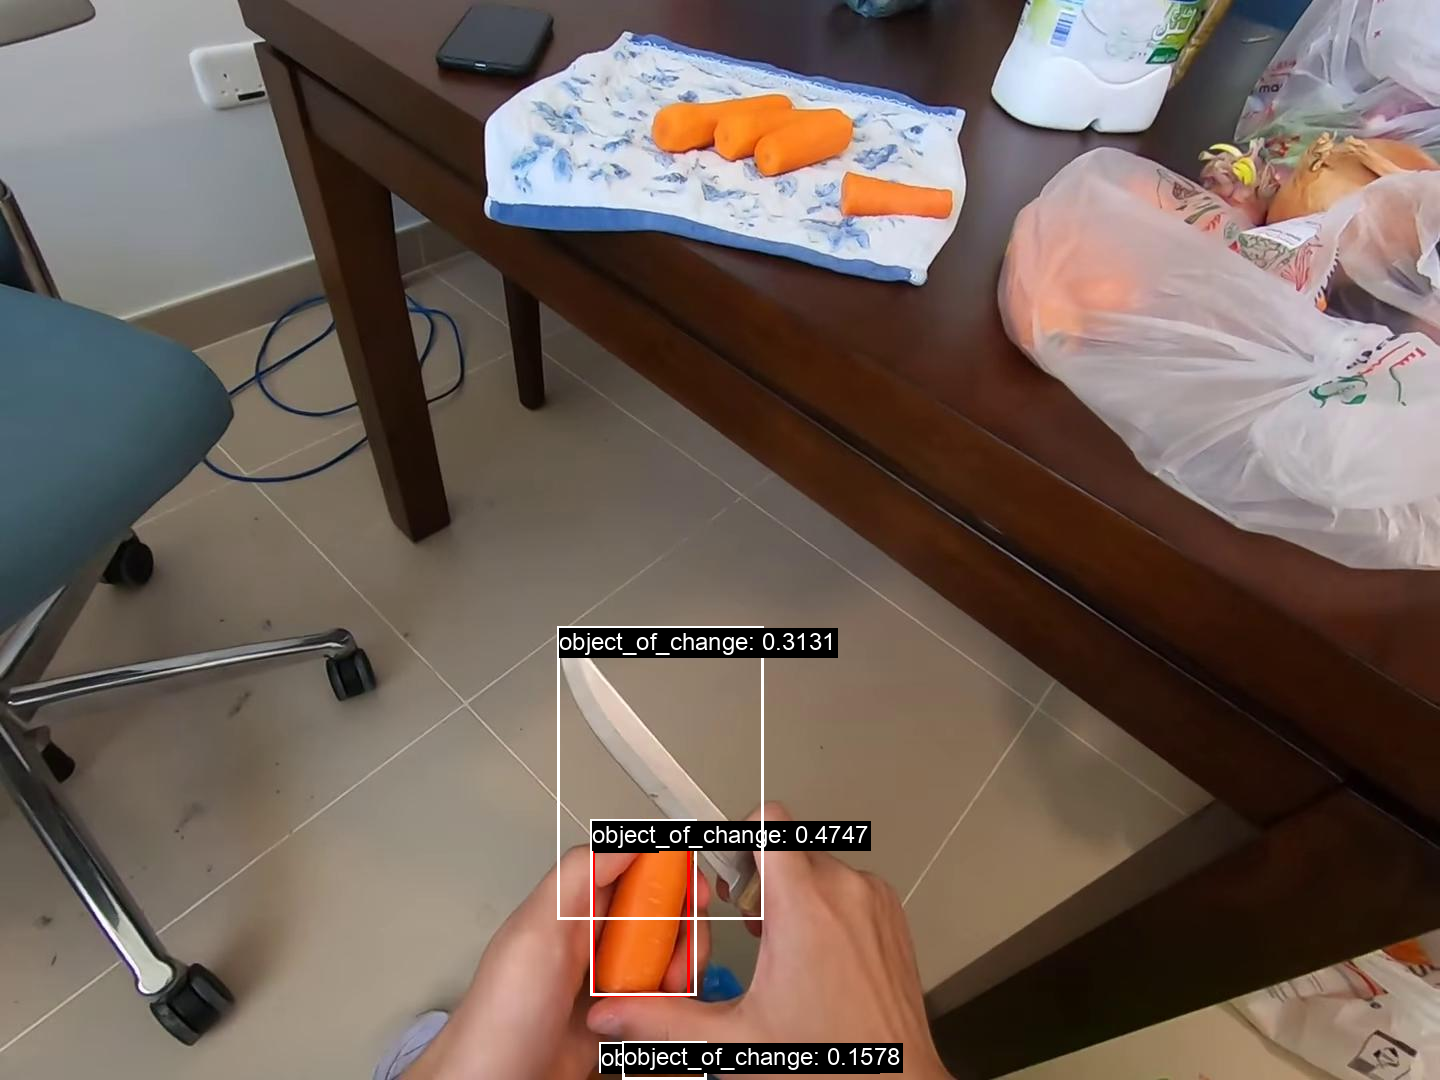

[{'AP50': 1.0, 'AP75': 1.0, 'bbox_score': 0.474698930978775},
 {'AP50': 0.0, 'AP75': 0.0, 'bbox_score': 0.3130645453929901},
 {'AP50': 0.0, 'AP75': 0.0, 'bbox_score': 0.2564835846424103},
 {'AP50': 0.0, 'AP75': 0.0, 'bbox_score': 0.1578281819820404}]
--------------------------------------------------


In [19]:
# To visualize one randomly sampled results, we can define certain criteria (can be none).
# individual precision score for AP50 is either 1 or 0 for each data point.
# So precision > 0 means correct, while <= 0 means wrong, for AP50 results.
# TODO(telinwu): when AP is incorporated, make the criteria more sophisticated.

# Current criteria is both result 3 and 4 should be wrong.
# TODO: can change the below criteria function.
best_k = 4
AP_KEY = "AP50" # From ["AP", "AP50", "AP75"], standard object detection average precision metrics.
BEST_AP_KEY = "Best-{}-{}".format(best_k, AP_KEY)
criteria = {
    # output_results_json_file_3: lambda x: (
    #     x["pnr_frame"][AP_KEY]["precision"] > 0 and
    #     # True
    #     x["pnr_frame"][BEST_AP_KEY]["precision"] > 0
    # ),
    # output_results_json_file_4: lambda x: (
    #     x["pnr_frame"][AP_KEY]["precision"] > 0 and
    #     x["pnr_frame"][BEST_AP_KEY]["precision"] > 0
    # ),
    output_results_json_file_12: lambda x: (
        x["pnr_frame"][AP_KEY]["precision"] > 0 and
        x["pnr_frame"][BEST_AP_KEY]["precision"] > 0
    ),
}
# criteria = None
keys_to_sample_from = keys

if criteria is not None:
    for file_name in criteria:
        fulfill_keys = []
        file_res = all_keyed_results[file_name]
        for data_key, data_res in file_res.items():
            if criteria[file_name](data_res):
                fulfill_keys.append(data_key)
        keys_to_sample_from = set(keys_to_sample_from).intersection(set(fulfill_keys))
    keys_to_sample_from = sorted(list(keys_to_sample_from))

print("Valid results fulfilling the criteria: {}".format(len(keys_to_sample_from)))
print()

# Randomly sample a key.
rand_key = np.random.choice(keys_to_sample_from)
# rand_key = "c431062e-857c-4e9f-ad5c-94f925acc822_5920"
# rand_key = "689848c0-6488-4a4e-871c-c19d986532a4_55167"
# rand_key = "23ecfb5c-6d29-40a6-b070-5be19ba3e86f_105378"
# rand_key = "aea0b0dd-5aa0-44b9-8740-a5be68062623_1450"
# rand_key = "7c0c0057-3bbc-40ef-a91e-4d6e1a637642_53652"
# rand_key = "3d3efb83-4b41-41e3-94db-50f0f22e67ef_150830"
# rand_key = "b493e8e3-4e18-4480-8e63-c21e25bf99f7_964"
# rand_key = "3d3efb83-4b41-41e3-94db-50f0f22e67ef_148338"
# rand_key = "90a0c76e-f62f-4f49-888f-5478b6ccab5b_5751"
# rand_key = "4066339d-b061-4550-a8fa-988fc4861714_19505"
print("{}: {}".format(bold_text("Sampled Key:"), rand_key))

additional_description = None # "The paintbrush."

# TODO: decide which inference file results should be shown.
named_result_tuple_list = [
    # (output_results_json_file_1, output_results["output_results_1"][rand_key]),
    # (output_results_json_file_2, output_results["output_results_2"][rand_key]),
    # (output_results_json_file_3, output_results["output_results_3"][rand_key]),
    # (output_results_json_file_4, output_results["output_results_4"][rand_key]),
    # (output_results_json_file_9, output_results["output_results_9"][rand_key]),
    # (output_results_json_file_10, output_results["output_results_10"][rand_key]),
    (output_results_json_file_12, output_results["output_results_12"][rand_key]),
]

# Gets the narration for reference.
clip_narrations, closest_narrations = get_scod_clipped_narrations(
    keyed_scod_clips[rand_key],
    all_narrations,
    curr_videos_root,
    narration_pass="narration_pass_1",
    anchor_frame="pnr",
    top_k=5,
    verbose=True,
)

# Show the results.
# `frame_keys` here define which frames to be shown.
# If the prediction results do not contain certain specified frames, the images
# will just show the GT bbox (in red).
# TODO: can change `bbox_width`, `label_font_size`, and `resize_image_width`,
# where the `resize_image_width` resizes image widht and height will follow the aspect ratio.

region_proposal_probings = {
    "caption_func": None,
    # "caption_func": model,
    # "clip_func": None,
    "clip_func": (clip_processor, clip_model),
    "srl_func": predictor_srl,
    # "dp_func": predictor_dp,
}
region_proposal_probings = None

visualize_glip_results_comparisons(
    named_result_tuple_list,
    #top_k_bboxes=top_k,
    top_k_bboxes=4,
    resize_image_width=None,
    # frame_keys=["pre", "pnr", "post"],
    # frame_keys=["pre", "pnr"],
    frame_keys=["pnr"],
    bbox_width=3,
    label_font_size=24,
    scod_clip=keyed_scod_clips[rand_key],
    image_folder="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_png_frames",
    region_proposal_probings=region_proposal_probings,
    narration=closest_narrations[0][-1],
    additional_description=additional_description,
    print_performance=True,
)

### Re-rank Functions

**Run once for the imports!**

In [5]:
# Use our own built-in customized COCO API.
sys.path.insert(0, "../cocoapi")

from PythonAPI.pycocotools.coco import COCO
from PythonAPI.pycocotools.cocoeval import COCOeval

import inspect
print("COCO API at:     {}".format(inspect.getfile(COCO)))
print("COCOeval API at: {}".format(inspect.getfile(COCOeval)))

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

COCO API at:     /local1/bryanzhou008/jarvis/project_jarvis/modeling/../cocoapi/PythonAPI/pycocotools/coco.py
COCOeval API at: /local1/bryanzhou008/jarvis/project_jarvis/modeling/../cocoapi/PythonAPI/pycocotools/cocoeval.py


In [6]:
def coco_results(
    coco_gt_data,
    coco_pred_data,
    top_k=None,
    ignore_summaries=None,
    verbose=False,
):
    coco_gt = COCO(annotation_file=coco_gt_data, verbose=verbose)
    coco_dt = coco_gt.loadRes(coco_pred_data)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.params.verbose = verbose
    if top_k is not None:
        print("Using Top-{} Results!".format(top_k))
        coco_eval.params.maxDets = [top_k, top_k, top_k]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize(ignore_summaries=ignore_summaries)
    return coco_eval

In [7]:
def compare_reranking_performance(
    results_dict=None,
    list_of_keys=None,
    rerank_func=None,
    narration_refine_func=None,
    curr_videos_root=None,
    all_narrations=None,
    keyed_scod_clips=None,
    frame_type="pnr",
    top_k=None,
):  
    images = []
    annotations = []
    predictions = []
    reranked_predictions = []
    
    # We only have `object_of_change` for now.
    categories = [
        {
            "id": 1,
            "name": "object_of_change",
            "supercategory": "object"
        }
    ]
    
    # IDs start with 1 for safer operations.
    # (As coco api uses logical not to define false positives.)
    _id = 1
    _annot_id = 1
    
    for key in list_of_keys:
        if "{}_frame".format(frame_type) not in results_dict[key]:
            continue
        result_to_use = results_dict[key]["{}_frame".format(frame_type)]
        gt_bboxes = result_to_use["gt_bboxes"]
        pred_bboxes = result_to_use["pred_bboxes"]
        image_folder = result_to_use["image_folder"]
        image_file_name = result_to_use["image_name"]
        image_path = os.path.join(image_folder, image_file_name)

        # Gets the narration for reference.
        clip_narrations, closest_narrations = get_scod_clipped_narrations(
            keyed_scod_clips[key],
            all_narrations,
            curr_videos_root,
            narration_pass="narration_pass_1",
            anchor_frame="pnr",
            top_k=5,
            verbose=False,
        )
        if len(closest_narrations) == 0:
            continue
        narration = narration_refine_func(closest_narrations[0][-1])
        
        _image = {
            "file_name": image_file_name,
            "width": 1920,
            "height": 1080,
            "id": _id,
        }
        images.append(_image)
        
        metadata = []
        for pred_bbox in pred_bboxes:
            bbox = pred_bbox["bbox"]
            cropped_bboxed_frame_image = Image.open(image_path).crop((
                bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]
            ))
            _d = {
                "score": pred_bbox["score"],
                "narration": narration,
                "cropped_region": cropped_bboxed_frame_image,
                "bbox": pred_bbox["bbox"],
            }
            metadata.append(_d)
        
        scores_before = [round(x["score"], 3) for x in metadata]
        # Copy the metadata.
        reranked_metadata = copy.deepcopy(metadata)
        reranked_metadata = rerank_func(reranked_metadata)
        scores_after = [round(x["score"], 3) for x in reranked_metadata]
        print("Before Re-rank BBox Scores (cnt={}):\n{}".format(len(scores_before), scores_before))
        print("After  Re-rank BBox Scores (cnt={}):\n{}".format(len(scores_after), scores_after))
        
        for gt_bbox in gt_bboxes:
            for d in metadata:
                _pred = {
                    "image_id": _id,
                    "category_id": 1,
                    "bbox": d["bbox"],
                    "score": d["score"],
                }
                predictions.append(_pred)
            for reranked_d in reranked_metadata:
                _reranked_pred = {
                    "image_id": _id,
                    "category_id": 1,
                    "bbox": reranked_d["bbox"],
                    "score": reranked_d["score"],
                }
                reranked_predictions.append(_reranked_pred)
            bbox = [
                gt_bbox["bbox"]["x"],     gt_bbox["bbox"]["y"],
                gt_bbox["bbox"]["width"], gt_bbox["bbox"]["height"]
            ]
            _annotation = {
                "segmentation": [],
                "area": bbox[2]*bbox[3],
                "iscrowd": 0,
                "ignore": 0,
                "image_id": _id,
                "bbox": bbox,
                "category_id": 1,
                "id": _annot_id,
            }
            annotations.append(_annotation)
            _annot_id += 1
        
        _id += 1

    if len(images) == 0:
        raise ValueError("Nothing in constructed image data, perhaps specify different frame types?")
        
    coco_gt_data = {
        "images": images,
        "annotations": annotations,
        "categories": categories,
    }
    
    ignore_summaries = {"area": ["small", "medium", "large"]}
    
    
    print("\n------------------------------ Performance Before Re-Ranking ------------------------------")
    coco_pred_data = predictions
    coco_results(
        coco_gt_data,
        coco_pred_data,
        top_k=top_k,
        ignore_summaries=ignore_summaries,
        verbose=False,
    )
    
    print("\n------------------------------ Performance After Re-Ranking ------------------------------")
    coco_pred_data = reranked_predictions
    coco_results(
        coco_gt_data,
        coco_pred_data,
        top_k=top_k,
        ignore_summaries=ignore_summaries,
        verbose=False,
    )
    
    return None

In [8]:
# Example usage.
# Note: re-ranking function needs to override the score field of the input data.
# Here the example is reverse the original ranking.
def naive_rerank_func(reranked_metadata):
    """
        metadata is a list of:
        {"bbox": ..., "label": ..., "score": ...}
    """
    print("reranked_metadata:", reranked_metadata, "\n")
    
    
    assert type(reranked_metadata) is list and type(reranked_metadata[0]) is dict
    rev_scores = np.linspace(0, 1, len(reranked_metadata))
    for idx in range(len(reranked_metadata)):
        d = reranked_metadata[idx]
        d["score"] = rev_scores[idx]
        assert "narration" in d
    return reranked_metadata

In [9]:
def test_rerank_func(reranked_metadata):
    
    assert type(reranked_metadata) is list and type(reranked_metadata[0]) is dict

# Get CLIP
# import CLIP encoder and model outside below
    clip_images = []
    scores = [m["score"] for m in reranked_metadata]
    for idx in range(len(reranked_metadata)):
        d = reranked_metadata[idx]
        narration = d["narration"]
        cropped_region = d["cropped_region"]
        clip_images.append(cropped_region)
    
# Parse Narration
    NARRATION = narration.strip().replace("C ", "A person ")
    bad_roots = ["C", "hand", "X", "A person", "piece"]

    whole_narration_noun_chunks = [chunk for chunk in list(dp_encoder(NARRATION).noun_chunks) if chunk.root.text not in bad_roots] 
    object_phrase_noun_chunks = [chunk for chunk in list(dp_encoder(str(get_object_phrase(dp_encoder(NARRATION)))).noun_chunks)if chunk.root.text not in bad_roots] 

    if len(object_phrase_noun_chunks) > 0 and object_phrase_noun_chunks[0].root.text != "None":
        object_phrase = object_phrase_noun_chunks[0].text
    elif len(whole_narration_noun_chunks) > 0 and whole_narration_noun_chunks[0].root.text != "None":
        object_phrase = whole_narration_noun_chunks[0].text
    else:
        object_phrase = "object being processed"

    texts = [object_phrase]

    print("My texts:", texts)

# Rank using CLIP
    inputs = clip_processor(
        text=[object_phrase], images=clip_images, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    logits_per_text = outputs.logits_per_text
    probs = logits_per_text.softmax(dim=1)


    probs = probs.detach().numpy()
    summed_probs = np.sum(probs, axis=0)
    new_summed_probs = summed_probs

    print("probs", probs)
    print("logits_per_text:", outputs.logits_per_text)
    print("new_summed_probs:", new_summed_probs)


    for idx in range(len(metadata)):
        d = metadata[idx]
        d["score"] = d["score"] + 
        assert "narration" in d
    return reranked_metadata

SyntaxError: invalid syntax (1313101665.py, line 52)

In [ ]:
# Arguments.
rand_key = np.random.choice(keys_to_sample_from)

# rerank_func = naive_rerank_func
rerank_func = test_rerank_func
results_dict = output_results["output_results_12"]
list_of_keys = [rand_key]
# Naive narration refine func, return identity narration.
narration_refine_func = lambda x: x

# Execute.
compare_reranking_performance(
    results_dict=results_dict,
    list_of_keys=list_of_keys,
    rerank_func=rerank_func,
    narration_refine_func=narration_refine_func,
    curr_videos_root=curr_videos_root,
    all_narrations=all_narrations,
    keyed_scod_clips=keyed_scod_clips,
    top_k=None,
)

In [ ]:
# Arguments.
rand_key = np.random.choice(keys_to_sample_from)
rand_key1 = np.random.choice(keys_to_sample_from)

rerank_func = naive_rerank_func
# rerank_func = test_rerank_func
results_dict = output_results["output_results_12"]
list_of_keys = [rand_key, rand_key1]
# Naive narration refine func, return identity narration.
narration_refine_func = lambda x: x

# Execute.
compare_reranking_performance(
    results_dict=results_dict,
    list_of_keys=list_of_keys,
    rerank_func=rerank_func,
    narration_refine_func=narration_refine_func,
    curr_videos_root=curr_videos_root,
    all_narrations=all_narrations,
    keyed_scod_clips=keyed_scod_clips,
    top_k=None,
)

# Imports

In [10]:
clip_model_name = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

NameError: name 'CLIPModel' is not defined

In [11]:
import spacy
dp_encoder = spacy.load('en_core_web_sm')

In [12]:
def get_subject_phrase(doc):
    for token in doc:
        if ("subj" in token.dep_):
            subtree = list(token.subtree)
            start = subtree[0].i
            end = subtree[-1].i + 1
            return doc[start:end]   
def get_object_phrase(doc):
    for token in doc:
        if ("dobj" in token.dep_):
            subtree = list(token.subtree)
            start = subtree[0].i
            end = subtree[-1].i + 1
            return doc[start:end]

In [43]:
def getSubstringBetweenTwoChars(ch1,ch2,str):
    return s.split(ch1)[1].split(ch2)[0]
s = "The object being acted upon is [the salmon]."
s2= getSubstringBetweenTwoChars('[',']',s)
print(s2)

the salmon


In [13]:
import openai

openai.api_key = "REMOVED_OPENAI_KEY"

In [37]:
prefix = "For the following sentence, Print the object being acted upon: "
sent = "C use the knife to cut the salmon"
prompt = prefix + sent

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

For the following sentence, Print the object being acted upon: C use the knife to cut the salmon
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "salmon",
        "role": "assistant"
      }
    }
  ],
  "created": 1682380579,
  "id": "chatcmpl-790KZVAyKUnUwUPIdTMYkSegSqoDH",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 2,
    "prompt_tokens": 28,
    "total_tokens": 30
  }
}


In [40]:
prefix = "For the following sentence, Print the object being acted upon:"
sent = "C changes the position of a phone on the slab with her left hand"
prompt = prefix + sent

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

For the following sentence, Print the object being acted upon:C changes the position of a phone on the slab with her left hand
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "phone",
        "role": "assistant"
      }
    }
  ],
  "created": 1682380635,
  "id": "chatcmpl-790LT81tgSFCf1SquSHg6jREOgfsR",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 1,
    "prompt_tokens": 33,
    "total_tokens": 34
  }
}


In [26]:
prefix = "Think step by step to find the object being acted upon in the sentence: "
sent = "C changes the position of the pot on the slab with both hands."
prompt = prefix + sent

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

Think step by step to find the object being acted upon in the sentence: C changes the position of the pot on the slab with both hands.
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "1. Who is performing the action? - C \n2. What is the action being performed? - changes the position \n3. What is the object of the action? - the pot \n4. Where is the pot being changed? - on the slab \n5. How is C changing the position of the pot? - with both hands",
        "role": "assistant"
      }
    }
  ],
  "created": 1682532594,
  "id": "chatcmpl-79dsQLntsWp7JtddgoxbIwpfSFgXl",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 69,
    "prompt_tokens": 37,
    "total_tokens": 106
  }
}


In [23]:
prefix = "Think step by step to find the object being acted upon in the sentence: "
sent = "C use the knife to cut the salmon"
prompt = prefix + sent

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

Think step by step to find the object being acted upon in the sentence: C use the knife to cut the salmon
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Subject: C\nVerb: use\nObject: the knife\nAction: to cut\nObject being acted upon: the salmon",
        "role": "assistant"
      }
    }
  ],
  "created": 1682532328,
  "id": "chatcmpl-79do8HrajKkJTmeoLNhu5B3AuXv45",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 25,
    "prompt_tokens": 31,
    "total_tokens": 56
  }
}


In [22]:
prefix = 'Think step by step to find the object being acted upon in the sentence: "{'
sent = 'C drops the plastic bag of network cable connectors on the shelf'
postfix = '}"'
prompt = prefix + sent + postfix

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

Think step by step to find the object being acted upon in the sentence: "{C drops the plastic bag of network cable connectors on the shelf}"
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "1. Who is performing the action?\n\nC\n\n2. What is the action being performed?\n\nDrops\n\n3. What is being dropped?\n\nThe plastic bag of network cable connectors\n\n4. Where is it being dropped?\n\nOn the shelf\n\nTherefore, the object being acted upon in the sentence is the plastic bag of network cable connectors.",
        "role": "assistant"
      }
    }
  ],
  "created": 1682532271,
  "id": "chatcmpl-79dnDl6lGW2e5IlXvXKU3b12j21HC",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 68,
    "prompt_tokens": 37,
    "total_tokens": 105
  }
}


## GPT-4

### CoT

In [28]:
prefix = 'Think step by step to find the object being acted upon in the sentence: '
sent = '{C drops the plastic bag of network cable connectors on the shelf}'
postfix = ', state the final answer in between < >'
prompt = prefix + sent + postfix

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-4-0314",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

Think step by step to find the object being acted upon in the sentence: {C drops the plastic bag of network cable connectors on the shelf}, state the final answer in between < >
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Step 1: Identify the main action in the sentence. The main action is \"drops.\"\nStep 2: Identify the subject performing the action. The subject is \"C.\"\nStep 3: Identify the object being acted upon by the subject. The object is the \"plastic bag of network cable connectors.\"\nStep 4: Identify the final destination of the action. The destination is \"on the shelf.\"\n\nFinal answer: <plastic bag of network cable connectors>",
        "role": "assistant"
      }
    }
  ],
  "created": 1682532728,
  "id": "chatcmpl-79duaf0sKq6WNsz4xoyHu5VxlMV9q",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 95,
    "prompt_tokens": 44,
    "total_tokens": 139
  }
}


In [29]:
prefix = 'Think step by step to find the object being acted upon in the sentence: '
sent = '{C use the knife to cut the salmon}'
postfix = ', state the final answer in between < >'
prompt = prefix + sent + postfix

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-4-0314",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

Think step by step to find the object being acted upon in the sentence: {C use the knife to cut the salmon}, state the final answer in between < >
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "1. Identify the action taking place: \"cut\"\n2. Look for the subject performing the action: \"C\"\n3. Identify the tool being used for the action: \"knife\"\n4. Look for the object the action is being performed on, related to the action \"cut\": \"salmon\"\n\nFinal answer: <salmon>",
        "role": "assistant"
      }
    }
  ],
  "created": 1682532786,
  "id": "chatcmpl-79dvWyUnUUootp5B0tmF9un4cjSQK",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 69,
    "prompt_tokens": 40,
    "total_tokens": 109
  }
}


In [30]:
prefix = 'Think step by step to find the object being acted upon in the sentence: '
sent = '{C changes the position of the pot on the slab with both hands}'
postfix = ', state the final answer in between < >'
prompt = prefix + sent + postfix

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-4-0314",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

Think step by step to find the object being acted upon in the sentence: {C changes the position of the pot on the slab with both hands}, state the final answer in between < >
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "1. Identify the main action in the sentence: \"changes the position.\"\n2. Determine the subject performing the action: \"C.\"\n3. Identify words following the main action or verb: \"of the pot on the slab with both hands.\"\n4. Focus on the prepositional phrase \"of the pot\" that indicates the object being changed.\n5. Extract the object being acted upon: \"the pot.\"\n6. Provide the final answer: <the pot>.",
        "role": "assistant"
      }
    }
  ],
  "created": 1682532840,
  "id": "chatcmpl-79dwObNEW3dVP5D7isYX28M5PZSwh",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 94,
    "prompt_tokens": 45,
    "total_tokens": 139
  }
}


### No CoT

In [31]:
prefix = "For the following sentence, Print the object being acted upon: "
sent = "{C use the knife to cut the salmon}"
prompt = prefix + sent

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-4",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

For the following sentence, Print the object being acted upon: {C use the knife to cut the salmon}
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "the salmon",
        "role": "assistant"
      }
    }
  ],
  "created": 1682533339,
  "id": "chatcmpl-79e4RFR8p2mn9wbMTGFDorh3us46L",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 2,
    "prompt_tokens": 29,
    "total_tokens": 31
  }
}


In [38]:
prefix = "For the following sentence, Print the object being acted upon:"
sent = "{C changes the position of a phone on the slab with her left hand}"
prompt = prefix + sent

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-4",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

For the following sentence, Print the object being acted upon:{C changes the position of a phone on the slab with her left hand}
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "phone",
        "role": "assistant"
      }
    }
  ],
  "created": 1682543354,
  "id": "chatcmpl-79gfyliAVdLKel6ZsX2qT95UHiXSl",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 1,
    "prompt_tokens": 34,
    "total_tokens": 35
  }
}


In [37]:
prefix = "For the following sentence, Print the object being acted upon:"
sent = "{C drops the plastic bag of network cable connectors on the shelf}"
prompt = prefix + sent

print(prompt)


result = openai.ChatCompletion.create(
  model="gpt-4",
  messages=[
        {"role": "system", "content": prompt},
    ]
)

print(result)

For the following sentence, Print the object being acted upon:{C drops the plastic bag of network cable connectors on the shelf}
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "the plastic bag of network cable connectors",
        "role": "assistant"
      }
    }
  ],
  "created": 1682543336,
  "id": "chatcmpl-79gfgPQ4khre1fIGbIvkBqc4BDcfo",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 7,
    "prompt_tokens": 32,
    "total_tokens": 39
  }
}


In [36]:
print(result["choices"][0]["message"]["content"])

plastic bag of network cable connectors


In [90]:
def GPT_Extract(input_sent, model="gpt-3.5-turbo-0301", cot=False):
    
    if cot == True:
        prefix = 'Think step by step to find the object being acted upon in the sentence: '
        sent = '{' + input_sent + '}'
        postfix = ', print the final object in between < >'
    else:
        prefix = "For the following sentence, only print the object being acted upon: "
        sent = '{' + input_sent + '}'
        postfix = ''
    
    prompt = prefix + sent + postfix
    print(bold_text("Prompt:"), prompt)
    
    
    
    gpt_output = openai.ChatCompletion.create(
      model= model,
      messages=[
            {"role": "system", "content": prompt},
        ]
    )
    print(bold_text("GPT_output:"), gpt_output)
    
    
    ans = gpt_output["choices"][0]["message"]["content"]
    # if using cot, we must extract the output object from the cot reasoning
    if cot == True:
        ans = ans.split("<")[1].split(">")[0]
    print(bold_text("Ans:"), ans)
    
    
    # convert to lower case
    ans = ans.lower()
    
    return ans
        

In [71]:
# sent = "C drops the plastic bag of network cable connectors on the shelf"
# sent = "C use the knife to cut the salmon"
# sent = "C changes the position of a phone on the slab with her left hand"

# model = "gpt-4-0314"
model = "gpt-3.5-turbo-0301"


GPT_Extract(sent, model, cot=False)

Prompt: For the following sentence, only print the object being acted upon: {C changes the position of a phone on the slab with her left hand}
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "phone",
        "role": "assistant"
      }
    }
  ],
  "created": 1682544863,
  "id": "chatcmpl-79h4JASLWrKtD0EzdI4vjVkhR5vci",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 1,
    "prompt_tokens": 37,
    "total_tokens": 38
  }
}
Ans: phone


'phone'

# Intrinsic Eval

In [72]:
#load file from pkl
import pickle
with open('/local1/bryanzhou008/jarvis/ego4d/rerank/pnr_ID_TO_NARRATION_AND_LABELS.pkl', 'rb') as f:
    ID_TO_NARRATION_AND_LABELS = pickle.load(f)

In [73]:
print(ID_TO_NARRATION_AND_LABELS)

{'02cf2e59-26be-43be-a4d9-7d6cbcfd0898_74405': [{'narration': 'C picks the cards', 'gt_noun': ['playingcards']}], '02cf2e59-26be-43be-a4d9-7d6cbcfd0898_75281': [{'narration': 'lady X talks to C', 'gt_noun': ['playingcards']}], '02cf2e59-26be-43be-a4d9-7d6cbcfd0898_75808': [{'narration': 'lady X plays the cards', 'gt_noun': ['playingcards']}], '0377792b-7b1e-4d67-86fd-f50c9257ea85_2607': [{'narration': 'C straightens out the UTP cables of one of the network cables with his hand.', 'gt_noun': ['adapter', 'cable', 'charger', 'connector', 'cord', 'wire']}], '0377792b-7b1e-4d67-86fd-f50c9257ea85_318': [{'narration': 'C drops the plastic bag of network cable connectors on the shelve.', 'gt_noun': ['bag', 'grocery', 'nylon', 'polythene', 'pouch', 'sachet', 'sack', 'suitcase']}], '0377792b-7b1e-4d67-86fd-f50c9257ea85_5598': [{'narration': 'C drops the wire cutter on the shelve.', 'gt_noun': ['cutter', 'tool']}], '0377792b-7b1e-4d67-86fd-f50c9257ea85_5689': [{'narration': 'C fits in the network

In [96]:
import random

subset = []

for i in range(200):
    key, value = random.choice(list(ID_TO_NARRATION_AND_LABELS.items()))
    print(key)
    print(value)
    subset.append(value)

print(subset)
print(len(subset))

d38dad44-e3ef-43f0-8613-832757458348_19624
[{'narration': 'C picks a glass plate', 'gt_noun': ['dish', 'plate', 'platter', 'saucer']}]
162c1bc4-89df-4475-a549-3faa7ef27c1e_59338
[{'narration': 'C drops the game controller in his left hand on the chair. ', 'gt_noun': ['control', 'remote', 'remotecontrol']}]
1120c597-930c-49b7-8a61-f0dce9c31be5_1446
[{'narration': 'C opens the bottle with both hands', 'gt_noun': ['bottle', 'flask']}]
24898dc1-61bd-4e90-a034-2853b96e4a91_26049
[{'narration': 'C adjusts the material with her both hands.', 'gt_noun': ['block', 'material']}]
e9ab9c6c-acbf-45e7-bc5d-d7b305973f37_65576
[{'narration': 'C closes the phone pouch.', 'gt_noun': ['cellphone', 'phone', 'smartphone']}]
17324963-0877-482d-a189-11cc2862095c_36601
[{'narration': 'C passes the tablet device to her right hand', 'gt_noun': ['tablet']}]
11286c45-7869-4b84-81a5-7fcb9a247e9d_2275
[{'narration': 'C takes the sieve from the slab into the plate drainer with her left hand', 'gt_noun': ['sieve', 's

7b016e40-d10a-43b3-9222-cb4787a95432_4711
[{'narration': 'C places cloths on the table', 'gt_noun': ['cloth', 'fabric', 'garment', 'kanga', 'rag']}]
59815805-de31-4993-8f5e-f12b1537bcfc_56851
[{'narration': 'C irons the pants boxer on the pressing board with his right hand.', 'gt_noun': ['jean', 'pant', 'pants', 'short', 'trouser']}]
23ecfb5c-6d29-40a6-b070-5be19ba3e86f_113018
[{'narration': 'C cuts clay from the clay boulder with both hands', 'gt_noun': ['clay']}]
082db032-f3f2-408b-a116-84d62f673915_68380
[{'narration': 'C washes the clothes with her hands', 'gt_noun': ['cloth', 'fabric', 'garment', 'kanga', 'rag']}]
ee0a0b25-f06a-4e17-813b-248f99b2e8b8_83635
[{'narration': 'C drops the brick on the other bricks with his right hand', 'gt_noun': ['brick']}]
ad09372b-2863-4de9-a86c-c46b2f502fe4_99543
[{'narration': 'C drops the trouser on the ironing board with both hands\n', 'gt_noun': ['jean', 'pant', 'pants', 'short', 'trouser']}]
fac12c04-2d7a-4d3a-91da-f3bdbd15af89_24731
[{'narrat

In [95]:
# just GPT

inclusive_success = []
exclusive_success = []
impossible = []
all_failed = 0
num_samples = 0

for sample in subset:
    num_samples += 1
    NARRATION = sample[0]["narration"]
    LABELS = sample[0]["gt_noun"]
    print("Narration:",NARRATION)
    print("Labels:",LABELS)
    

    if sum([1 for label in LABELS if label in NARRATION]) == 0:
        impossible.append(1)
    
    
    # model = "gpt-4-0314"
    model = "gpt-3.5-turbo-0301"

    object_phrase = GPT_Extract(NARRATION, model, cot=False)
            
    print(bold_text("final object_phrase:"),object_phrase)   

    if sum([1 for label in LABELS if object_phrase in label]) > 0 or sum([1 for label in LABELS if label in object_phrase]) > 0:
        inclusive_success.append(1)
    else:
        inclusive_success.append(0)
    
    if object_phrase in LABELS:
        exclusive_success.append(1)
    else:
        exclusive_success.append(0)
    
    if sum([1 for label in LABELS if label in NARRATION]) != 0 and sum([1 for label in LABELS if object_phrase in label]) <= 0 and sum([1 for label in LABELS if label in object_phrase]) <= 0:
        print("epic-fail-1")
    
    
    
    print("inclusive_success rate:",sum(inclusive_success)/num_samples)
    print("exclusive_success rate:",sum(exclusive_success)/num_samples)
    print("impossible rate:",sum(impossible)/num_samples)
    print("no answer found rate:",sum(all_failed)/num_samples)
    print("\n")

Narration: C opens a detergent
Labels: ['detergent']
Prompt: For the following sentence, only print the object being acted upon: {C opens a detergent}
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "detergent",
        "role": "assistant"
      }
    }
  ],
  "created": 1682548866,
  "id": "chatcmpl-79i6spugZKaQ7xmeINXk0bvDh107s",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 3,
    "prompt_tokens": 27,
    "total_tokens": 30
  }
}
Ans: detergent
final object_phrase: detergent
inclusive_success rate: 1.0
exclusive_success rate: 1.0
impossible rate: 0.0
no answer found rate: 0.0


Narration: C holds bowl on in sink 
Labels: ['bowl']
Prompt: For the following sentence, only print the object being acted upon: {C holds bowl on in sink }
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "bow

GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "the bottle",
        "role": "assistant"
      }
    }
  ],
  "created": 1682548874,
  "id": "chatcmpl-79i70jWlWzSUfTeWsIrLXcqBC3EL7",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 2,
    "prompt_tokens": 30,
    "total_tokens": 32
  }
}
Ans: the bottle
final object_phrase: the bottle
inclusive_success rate: 0.8181818181818182
exclusive_success rate: 0.36363636363636365
impossible rate: 0.18181818181818182
no answer found rate: 0.0


Narration: C moves brick mould close
Labels: ['mold', 'molder', 'mould']
Prompt: For the following sentence, only print the object being acted upon: {C moves brick mould close}
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "brick mould",
        "role": "assistant"
      }
    }
  ],
  "created": 168254887

GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "pants boxer",
        "role": "assistant"
      }
    }
  ],
  "created": 1682548881,
  "id": "chatcmpl-79i77ntXIVMyOAcHIHITDjoQpkhWa",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 2,
    "prompt_tokens": 36,
    "total_tokens": 38
  }
}
Ans: pants boxer
final object_phrase: pants boxer
inclusive_success rate: 0.8095238095238095
exclusive_success rate: 0.38095238095238093
impossible rate: 0.14285714285714285
no answer found rate: 0.0


Narration: C drops the brick in his right hand on the bricks  in the yard
Labels: ['brick']
Prompt: For the following sentence, only print the object being acted upon: {C drops the brick in his right hand on the bricks  in the yard}
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Brick.",
        "role":

RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 7054f2d97cbb0343ffbda93198e6af2e in your message.)

In [97]:
# just GPT

inclusive_success = []
exclusive_success = []
impossible = []
all_failed = 0
num_samples = 0

for sample in subset:
    num_samples += 1
    NARRATION = sample[0]["narration"]
    LABELS = sample[0]["gt_noun"]
    print("Narration:",NARRATION)
    print("Labels:",LABELS)
    

    if sum([1 for label in LABELS if label in NARRATION]) == 0:
        impossible.append(1)
    
    
    model = "gpt-4-0314"
#     model = "gpt-3.5-turbo-0301"

    object_phrase = GPT_Extract(NARRATION, model, cot=False)
            
    print(bold_text("final object_phrase:"),object_phrase)   

    if sum([1 for label in LABELS if object_phrase in label]) > 0 or sum([1 for label in LABELS if label in object_phrase]) > 0:
        inclusive_success.append(1)
    else:
        inclusive_success.append(0)
    
    if object_phrase in LABELS:
        exclusive_success.append(1)
    else:
        exclusive_success.append(0)
    
    if sum([1 for label in LABELS if label in NARRATION]) != 0 and sum([1 for label in LABELS if object_phrase in label]) <= 0 and sum([1 for label in LABELS if label in object_phrase]) <= 0:
        print("epic-fail-2")
    
    
    
    print("inclusive_success rate:",sum(inclusive_success)/num_samples)
    print("exclusive_success rate:",sum(exclusive_success)/num_samples)
    print("impossible rate:",sum(impossible)/num_samples)
    print("no answer found rate:",sum(all_failed)/num_samples)
    print("\n")

Narration: C picks a glass plate
Labels: ['dish', 'plate', 'platter', 'saucer']
Prompt: For the following sentence, only print the object being acted upon: {C picks a glass plate}
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "glass plate",
        "role": "assistant"
      }
    }
  ],
  "created": 1682549209,
  "id": "chatcmpl-79iCPRBQLRGjZ5f5IiqYn876fjxLv",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 2,
    "prompt_tokens": 27,
    "total_tokens": 29
  }
}
Ans: glass plate
final object_phrase: glass plate
inclusive_success rate: 1.0
exclusive_success rate: 0.0
impossible rate: 0.0
no answer found rate: 0.0


Narration: C drops the game controller in his left hand on the chair. 
Labels: ['control', 'remote', 'remotecontrol']
Prompt: For the following sentence, only print the object being acted upon: {C drops the game controller in his left hand on the chair. }

GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "the tomato",
        "role": "assistant"
      }
    }
  ],
  "created": 1682549222,
  "id": "chatcmpl-79iCc4ygSqGmBfEXqftUOxAiPUYku",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 2,
    "prompt_tokens": 27,
    "total_tokens": 29
  }
}
Ans: the tomato
final object_phrase: the tomato
inclusive_success rate: 0.9090909090909091
exclusive_success rate: 0.18181818181818182
impossible rate: 0.09090909090909091
no answer found rate: 0.0


Narration: C mould the clay
Labels: ['clay']
Prompt: For the following sentence, only print the object being acted upon: {C mould the clay}
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "the clay",
        "role": "assistant"
      }
    }
  ],
  "created": 1682549224,
  "id": "chatcmpl-79iCeNDBjdKbK6aEBXQXhF9ZqNz

GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "towel",
        "role": "assistant"
      }
    }
  ],
  "created": 1682549235,
  "id": "chatcmpl-79iCpA5fBIOPFbufOok8qFw1Ni5S7",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 2,
    "prompt_tokens": 35,
    "total_tokens": 37
  }
}
Ans: towel
final object_phrase: towel
inclusive_success rate: 0.8571428571428571
exclusive_success rate: 0.23809523809523808
impossible rate: 0.09523809523809523
no answer found rate: 0.0


Narration: C picks another battery with his right hand.
Labels: ['battery']
Prompt: For the following sentence, only print the object being acted upon: {C picks another battery with his right hand.}
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "another battery",
        "role": "assistant"
      }
    }
  ],
  "created": 168254

GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "the cap of the marker",
        "role": "assistant"
      }
    }
  ],
  "created": 1682549248,
  "id": "chatcmpl-79iD2A14Ot6VZ66VY7JyIKUA1U63T",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 5,
    "prompt_tokens": 34,
    "total_tokens": 39
  }
}
Ans: the cap of the marker
final object_phrase: the cap of the marker
inclusive_success rate: 0.8387096774193549
exclusive_success rate: 0.16129032258064516
impossible rate: 0.12903225806451613
no answer found rate: 0.0


Narration: C drops the cellphone.
Labels: ['cellphone', 'phone', 'smartphone']
Prompt: For the following sentence, only print the object being acted upon: {C drops the cellphone.}
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "cellphone",
        "role": "assistant"
      }
    }
 

GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "steel rod",
        "role": "assistant"
      }
    }
  ],
  "created": 1682549261,
  "id": "chatcmpl-79iDFQC0fHO8IoSpEGcZndv4qr24z",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 2,
    "prompt_tokens": 32,
    "total_tokens": 34
  }
}
Ans: steel rod
final object_phrase: steel rod
inclusive_success rate: 0.8536585365853658
exclusive_success rate: 0.14634146341463414
impossible rate: 0.0975609756097561
no answer found rate: 0.0


Narration: c puts the hanger under the shirt
Labels: ['cardigan', 'shirt', 'sweater', 'sweatshirt', 'top']
Prompt: For the following sentence, only print the object being acted upon: {c puts the hanger under the shirt}
GPT_output: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "shirt",
        "role": "assistant"
      }
    }
  ]

RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID b20b2275fccd1f266fd5c2966fdebf4b in your message.)

In [ ]:
# just GPT

inclusive_success = []
exclusive_success = []
impossible = []
all_failed = 0
num_samples = 0

for sample in subset:
    num_samples += 1
    NARRATION = sample[0]["narration"]
    LABELS = sample[0]["gt_noun"]
    print("Narration:",NARRATION)
    print("Labels:",LABELS)
    

    if sum([1 for label in LABELS if label in NARRATION]) == 0:
        impossible.append(1)
    
    
#     model = "gpt-4-0314"
    model = "gpt-3.5-turbo-0301"

    object_phrase = GPT_Extract(NARRATION, model, cot=True)
            
    print(bold_text("final object_phrase:"),object_phrase)   

    if sum([1 for label in LABELS if object_phrase in label]) > 0 or sum([1 for label in LABELS if label in object_phrase]) > 0:
        inclusive_success.append(1)
    else:
        inclusive_success.append(0)
    
    if object_phrase in LABELS:
        exclusive_success.append(1)
    else:
        exclusive_success.append(0)
    
    if sum([1 for label in LABELS if label in NARRATION]) != 0 and sum([1 for label in LABELS if object_phrase in label]) <= 0 and sum([1 for label in LABELS if label in object_phrase]) <= 0:
        print("epic-fail-3")
    
    
    
    print("inclusive_success rate:",sum(inclusive_success)/num_samples)
    print("exclusive_success rate:",sum(exclusive_success)/num_samples)
    print("impossible rate:",sum(impossible)/num_samples)
    print("no answer found rate:",sum(all_failed)/num_samples)
    print("\n")

In [ ]:
# just GPT

inclusive_success = []
exclusive_success = []
impossible = []
all_failed = 0
num_samples = 0

for sample in subset:
    num_samples += 1
    NARRATION = sample[0]["narration"]
    LABELS = sample[0]["gt_noun"]
    print("Narration:",NARRATION)
    print("Labels:",LABELS)
    

    if sum([1 for label in LABELS if label in NARRATION]) == 0:
        impossible.append(1)
    
    
    model = "gpt-4-0314"
#     model = "gpt-3.5-turbo-0301"

    object_phrase = GPT_Extract(NARRATION, model, cot=True)
            
    print(bold_text("final object_phrase:"),object_phrase)   

    if sum([1 for label in LABELS if object_phrase in label]) > 0 or sum([1 for label in LABELS if label in object_phrase]) > 0:
        inclusive_success.append(1)
    else:
        inclusive_success.append(0)
    
    if object_phrase in LABELS:
        exclusive_success.append(1)
    else:
        exclusive_success.append(0)
    
    if sum([1 for label in LABELS if label in NARRATION]) != 0 and sum([1 for label in LABELS if object_phrase in label]) <= 0 and sum([1 for label in LABELS if label in object_phrase]) <= 0:
        print("epic-fail-4")
    
    
    
    print("inclusive_success rate:",sum(inclusive_success)/num_samples)
    print("exclusive_success rate:",sum(exclusive_success)/num_samples)
    print("impossible rate:",sum(impossible)/num_samples)
    print("no answer found rate:",sum(all_failed)/num_samples)
    print("\n")

# END